# on-target and off-target calculations

In [223]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
all_stats = glob.glob("short_stats/*.csv")

# All positions on one plot

In [ ]:
ABE710_files = sorted([fn for fn in all_stats if (("ABE710" in fn) or ("B2" in fn))]) 
ABE8e_files = sorted([fn for fn in all_stats if (("ABE8e" in fn) or ("on-C2" in fn))])
EB5control_files = sorted([fn for fn in all_stats if "EB5control" in fn or "B5" in fn])
NHF_files = sorted([fn for fn in all_stats if "off-NHF" in fn or "B1" in fn])

In [ ]:
ordering = [9,0,3,4,5,6,7,8,1,2]
ABE710_files = [ABE710_files[i] for i  in ordering]
ABE8e_files =  [ABE8e_files[i] for i  in ordering]
EB5control_files =  [EB5control_files[i] for i  in ordering]
NHF_files =  [NHF_files[i] for i  in ordering]
labels = ["On-target", "Bystander"]+[f"#{i}OT" for i in [1,2,3,4,5,6,7,10,11]]
target_strand = ['p', 'n', 'p', 'n', 'n', 'p', 'p', 'p', 'n', 'n']

In [227]:
positions = pd.read_csv("test_positions.csv")
positions

,target,locus,offtargetSeq,mismatchPos,chrom,chr,start,end,strand
0,on_target,exon:COL7A1,ACATTTCGTCCATCCTCTCCAGG,.......*............,chr3,3,48580579,48580601,p
1,#1OT,intron:ARL10,GCATCTCAGCCACCCTCTCCAGG,*...*...*...*.......,chr5,5,176369071,176369093,n
2,#2OT,exon:RAB7B,ACATCTTGTCCACCCTCTCCAGG,....*.**....*.......,chr1,1,205977216,205977238,p
3,#3OT,exon:ANKFN1,ACAGTTCACTCACCCTCTCCTGG,...*....**..*.......,chr17,17,56372698,56372720,n
4,#4OT,intron:ADAMTS12,ACATTTGAATCATCCTCTCCTGG,......*.**..........,chr5,5,33770608,33770630,n
5,#5OT,intergenic:SPOCK1-AC106775.1,ATACTTCACCCAACCTCTCCTGG,.*.*....*...*.......,chr5,5,137520993,137521015,p
6,#6OT,intron:GSAP,AATTTTCATCCACCCACTCCTGG,.**.........*..*....,chr7,7,77346765,77346787,p
7,#7OT,intergenic:AC009410.1-AC074019.1,CCATCCCATCCATCCTCTTCTGG,*...**............*.,chr2,2,228655082,228655104,p
8,#8OT,intron:KCNAB1,TCATTGCAACCATCCCCTCCTGG,*....*..*......*....,chr3,3,156375892,156375914,p
9,#9OT,intergenic:AC009977.1-RP11-424G14.1,CTATTCCATCCATCCTCTTCTGG,**...*............*.,chrY,0,19648527,19648549,p


# On-target normalised

In [ ]:
ABE710_file = ([fn for fn in all_stats if ("B2" in fn)]) 
ABE8e_file = ([fn for fn in all_stats if (("on-C2" in fn))])
EB5control_file = ([fn for fn in all_stats if "B5_S10" in fn])

In [ ]:
ordering = [0]
ABE710_files = [ABE710_files[i] for i  in ordering]
ABE8e_files =  [ABE8e_files[i] for i  in ordering]
labels = ["On-target c.5047"]
target_strand = ['p']

In [230]:
from scipy.stats import norm
import numpy as np
from statsmodels.stats.proportion import test_proportions_2indep
from statsmodels.stats.proportion import proportion_confint

count1=25
nobs1=50
count2=4
nobs2=10

alpha=0.05
method_CI='normal'

prop_test = test_proportions_2indep(count1=count1, 
                        nobs1=nobs1, 
                        count2=count2, 
                        nobs2=nobs2,
                        method="wald"
                       )

def get_count_and_nobs_for_ontarget(editor_files, target_strand, alpha = 0.05):
    counts = []
    nobs = []
    assert len(editor_files) == len(target_strand)
    for idx in range(len(editor_files)):
        fn = editor_files[idx]
        strand = target_strand[idx]
        df = pd.read_csv(fn, index_col=0)

        if idx == 0 : # for on target, chr3, 48580586
            # mutation:
            mut = df.iloc[7, :]
            assert mut["pos"] == 48580586
            counts.append(mut["G_pp"])
            nobs.append(mut["reads_pp"])
            A_G_mut_proc = mut["G_pp"]/mut["reads_pp"]*100
            efficiency = (A_G_mut_proc - 54.03)/ (100 - 54.03)*100
            print(f"efficiency {efficiency:.2f}")
    return np.array(counts), np.array(nobs)
    
def compute_CI(counts, nobs):
    CI = []
    for c,n in zip(counts, nobs):
        CI_temp = proportion_confint(count=c, 
                   nobs=n, 
                   alpha=alpha, 
                   method=method_CI)
        CI.append(CI_temp)
    return np.array(CI).T

def get_bars_errors(files, strand, get_counts_and_nobs, normalize=None):
    counts, nobs = get_counts_and_nobs(files, strand)
    bars = counts/nobs * 100
    if normalize is not None: 
        bars = (bars - normalize)/ (100 - normalize)*100
    errors = compute_CI(counts, nobs)
    return bars, errors, counts, nobs

def test_two_proportions(counts1, nobs1, counts2, nobs2, alpha=0.05):
    rejection = []
    for c1,n1, c2, n2 in zip(counts1, nobs1, counts2, nobs2):
        prop_temp = test_proportions_2indep(
                        count1=c1, 
                        nobs1=n1, 
                        count2=c2, 
                        nobs2=n2,
                        method="wald"
                       )
        rejection.append(prop_temp.pvalue<alpha)
    return np.array(rejection)
        
        
print("# ------------------------ ABE710_files")
ABE710_bars, ABE710_errors, ABE710_counts, ABE710_nobs = get_bars_errors(ABE710_files, 
                                                                         target_strand,
                                                                         get_counts_and_nobs=get_count_and_nobs_for_ontarget,
                                                                         normalize=54.03
                                                                        )
print(ABE710_bars)

print("# ------------------------ ABE8e_files")
ABE8e_bars, ABE8e_errors, ABE8e_counts, ABE8e_nobs = get_bars_errors(ABE8e_files, 
                                                                     target_strand,
                                                                     get_counts_and_nobs=get_count_and_nobs_for_ontarget,
                                                                     normalize=54.03
                                                                    )
print(ABE8e_bars)

h0_rejection = test_two_proportions(ABE710_counts, ABE710_nobs, ABE8e_counts, ABE8e_nobs, alpha=0.05)

# ------------------------ ABE710_files
efficiency 12.42
[12.42007586]
# ------------------------ ABE8e_files
efficiency 94.61
[94.6085528]


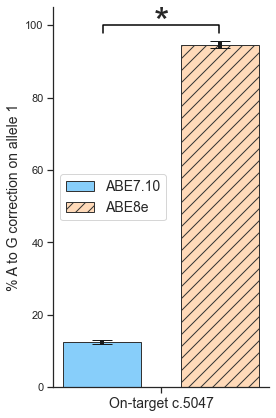

In [231]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


x1 = [-0.5]
x2 = [0.5]
width = 0.66

fig, ax = plt.subplots(figsize=(4,6))
rects1 = ax.bar(x1, ABE710_bars, 
                width, 
                label='ABE7.10',
                yerr=ABE710_errors, 
                capsize=10, 
                error_kw={"elinewidth":4},
                facecolor ='lightskyblue',
                linewidth=1.0, 
                hatch = "",
                edgecolor=".2"
               )
rects2 = ax.bar(x2, ABE8e_bars, width, 
                label='ABE8e',
                yerr=ABE8e_errors,
                capsize=10, 
                error_kw={"elinewidth":4},
                facecolor ='peachpuff',
                linewidth=1.0, 
                hatch = "//",
                edgecolor=".2"
               )

shortening = 0.01
tick = 2
for xx1,xx2, asterisk in zip(x1, x2, h0_rejection_ABE710_ABE8e):
    if asterisk:
        level = 100
        ax.plot([xx1+shortening,xx1+shortening, xx2-shortening,xx2-shortening],[level-tick,level,level,level-tick],color="black")
        ax.text((xx1+xx2)/2, level, '*', horizontalalignment='center', verticalalignment='center', fontsize=40)


        
ax.set_ylabel('% A to G correction on allele 1',fontsize=14)
ax.set_xticks([0.0])
ax.set_xticklabels(labels,fontsize=14)
ax.legend(fontsize=14)


fig.tight_layout()
plt.savefig("26042022_ontargetc5047_errorbar.png", dpi=300)

In [232]:
import numpy as np
from statsmodels.stats.proportion import test_proportions_2indep
from statsmodels.stats.proportion import proportion_confint

count1=25
nobs1=50
count2=4
nobs2=10

alpha=0.05
method_CI='normal'

prop_test = test_proportions_2indep(count1=count1, 
                        nobs1=nobs1, 
                        count2=count2, 
                        nobs2=nobs2,
                        method="wald"
                       )

CI_1 = proportion_confint(count=count1, 
                   nobs=nobs1, 
                   alpha=alpha, 
                   method=method_CI)

CI_2 = proportion_confint(count=count2, 
                   nobs=nobs2, 
                   alpha=alpha, 
                   method=method_CI)

print(prop_test)
print(prop_test.pvalue)
print(CI_1)
print(CI_2)

statistic = 0.5872202195147033
pvalue = 0.5570558144094062
compare = diff
method = wald
diff = 0.09999999999999998
ratio = 1.25
odds_ratio = 1.5
variance = 0.029
alternative = two-sided
value = 0
tuple = (0.5872202195147033, 0.5570558144094062)
0.5570558144094062
(0.3614096175650322, 0.6385903824349678)
(0.09636368514840155, 0.7036363148515985)


# Bystander and OTs

In [ ]:
ABE710_files_all = sorted([fn for fn in all_stats if (("ABE710" in fn) or ("B2" in fn))]) 
ABE8e_files_all = sorted([fn for fn in all_stats if (("ABE8e" in fn) or ("on-C2" in fn))])
EB5control_files_all = sorted([fn for fn in all_stats if "EB5control" in fn or "B5" in fn])
NHF_files_all = sorted([fn for fn in all_stats if "off-NHF" in fn or "B1" in fn])

In [ ]:
def get_count_and_nobs_for_bystander(editor_files, target_strand, alpha = 0.05):
#     bar_hights = []
#     bar_errors = []
    counts=[]
    nobs=[]
    assert len(editor_files) == len(target_strand)
    for idx in range(len(editor_files)):
        fn = editor_files[idx]
        strand = target_strand[idx]
        df = pd.read_csv(fn, index_col=0)

        # bystander:
        bys = df.iloc[2, :]
        assert bys["pos"] == 48580581
        counts.append(bys["G_pp"])
        nobs.append(bys["reads_pp"])
        
        # print check:
        A_G_bys_proc = bys["G_pp"]/bys["reads_pp"]*100
        print(f"A_G_bys_proc {A_G_bys_proc:.2f}")
    return np.array(counts), np.array(nobs)

ordering = [9]
ABE710_files = [ABE710_files_all[i] for i  in ordering]
ABE8e_files =  [ABE8e_files_all[i] for i  in ordering]
EB5control_files =  [EB5control_files_all[i] for i  in ordering]
NHF_files =  [NHF_files_all[i] for i  in ordering]
labels = ["Bystender c.5052"]
target_strand = ['p'] # checked visually below
print(ABE710_files)

# ABE710_files
# ABE8e_files
# EB5control_files
print("# ------------------------ ABE710_files")
ABE710_bars, ABE710_errors, ABE710_counts, ABE710_nobs = get_bars_errors(ABE710_files, target_strand,
                                             get_counts_and_nobs=get_count_and_nobs_for_bystander,
                                             normalize=None
                                            )
print(ABE710_bars)
print("# ------------------------ ABE8e_files")
ABE8e_bars, ABE8e_errors, ABE8e_counts, ABE8e_nobs = get_bars_errors(ABE8e_files, target_strand,
                                             get_counts_and_nobs=get_count_and_nobs_for_bystander,
                                             normalize=None
                                            )
print("# ------------------------ EB5control_files")
EB5control_bars, EB5control_errors, EB5control_counts, EB5control_nobs = get_bars_errors(EB5control_files, target_strand,
                                             get_counts_and_nobs=get_count_and_nobs_for_bystander,
                                             normalize=None
                                            )
print("# ------------------------ NHF_files")
NHF_bars, NHF_errors, NHF_counts, NHF_nobs = get_bars_errors(NHF_files, target_strand,
                                             get_counts_and_nobs=get_count_and_nobs_for_bystander,
                                             normalize=None)

h0_rejection_ABE710_ABE8e = test_two_proportions(ABE710_counts, ABE710_nobs, ABE8e_counts, ABE8e_nobs, alpha=0.05)
h0_rejection_ABE710_EB5control = test_two_proportions(ABE710_counts, ABE710_nobs, EB5control_counts, EB5control_nobs, alpha=0.05)
h0_rejection_EB5control_ABE8e = test_two_proportions(EB5control_counts, EB5control_nobs, ABE8e_counts, ABE8e_nobs, alpha=0.05)

[0]


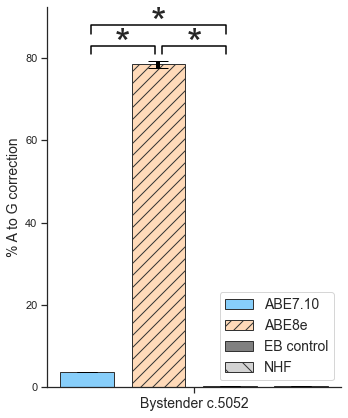

In [236]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

x = np.arange(len(labels))
width = 0.20
width_scalling = 0.75
fig, ax = plt.subplots(figsize=(5,6))
x1 = x - 1.5*width
x2 = x - 0.5*width
x3 = x + 0.5*width
x4 = x + 1.5*width
rects1 = ax.bar(x1, 
                ABE710_bars, 
                width*width_scalling, 
                label='ABE7.10', 
                yerr=ABE710_errors,
                capsize=10, 
                error_kw={"elinewidth":4,"ecolor":"black"},
                facecolor ='lightskyblue',
                linewidth=1.0, 
                hatch = "",
                edgecolor=".2")
rects2 = ax.bar(x2, 
                ABE8e_bars, 
                width*width_scalling, 
                label='ABE8e', 
                yerr=ABE8e_errors,
                capsize=10, 
                error_kw={"elinewidth":4,"ecolor":"black"},
                facecolor ='peachpuff',
                linewidth=1.0, 
                hatch = "//",
                edgecolor=".2")
rects3 = ax.bar(x3, 
                EB5control_bars, 
                width*width_scalling, 
                label='EB control', 
                yerr=EB5control_errors,
                capsize=10, 
                error_kw={"elinewidth":4,"ecolor":"black"},
                facecolor ='gray',
                linewidth=1.0, 
                hatch = "",
                edgecolor=".2")
rects4 = ax.bar(x4, 
                NHF_bars, 
                width*width_scalling, 
                label='NHF', 
                yerr=NHF_errors,
                capsize=10, 
                error_kw={"elinewidth":4,"ecolor":"black"},
                facecolor ='lightgray',
                linewidth=1.0, 
                hatch = "\\",
                edgecolor=".2")

shortening = 0.01
tick = 2
for xx1,xx2, asterisk in zip(x1, x2, h0_rejection_ABE710_ABE8e):
    if asterisk:
        level = 83
        ax.plot([xx1+shortening,xx1+shortening, xx2-shortening,xx2-shortening],[level-tick,level,level,level-tick],color="black")
        ax.text((xx1+xx2)/2, level, '*', horizontalalignment='center', verticalalignment='center', fontsize=40)

for xx1,xx2, asterisk in zip(x1, x3, h0_rejection_ABE710_EB5control):
    if asterisk:
        level = 88
        ax.plot([xx1+shortening,xx1+shortening, xx2-shortening,xx2-shortening],[level-tick,level,level,level-tick],color="black")
        ax.text((xx1+xx2)/2, level, '*', horizontalalignment='center', verticalalignment='center', fontsize=40)


for xx1,xx2, asterisk in zip(x2, x3, h0_rejection_EB5control_ABE8e):
    if asterisk:
        level = 83
        ax.plot([xx1+shortening,xx1+shortening, xx2-shortening,xx2-shortening],[level-tick,level,level,level-tick],color="black")
        ax.text((xx1+xx2)/2, level, '*', horizontalalignment='center', verticalalignment='center', fontsize=40)


ax.set_ylabel('% A to G correction', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=14)
ax.legend(fontsize=14)

fig.tight_layout()
plt.savefig("26042022_bystenderc5052_errorbar.png", dpi=300)

In [ ]:
def get_count_and_nobs_for_offtargets(editor_files, target_strand, alpha = 0.05):
    counts = []
    nobs = []
    assert len(editor_files) == len(target_strand)
    for idx in range(len(editor_files)):
        fn = editor_files[idx]
        strand = target_strand[idx]
        df = pd.read_csv(fn, index_col=0)

        positions = np.arange(-9,-2) if strand == "n" else np.arange(2,9)
        region_of_interest = df.iloc[positions,:]
        region_of_interest_A = region_of_interest[region_of_interest["ref"] == "A"]
        region_of_interest_T = region_of_interest[region_of_interest["ref"] == "T"]
        roi_A = region_of_interest_A.sum(axis=0)
        roi_T = region_of_interest_T.sum(axis=0)
        reads = roi_A["reads_pp"] + roi_T["reads_pp"]
        changes = roi_A["G_pp"] + roi_T["C_pp"]
        AT_GC_proc = changes/reads*100
        print(f"AT_GC_proc   {AT_GC_proc:.2f}")
        counts.append(changes)
        nobs.append(reads)
    return np.array(counts), np.array(nobs)

ordering = [0,3,4,5,6,7,8,1,2]
ABE710_files = [ABE710_files_all[i] for i  in ordering]
ABE8e_files =  [ABE8e_files_all[i] for i  in ordering]
EB5control_files =  [EB5control_files_all[i] for i  in ordering]
NHF_files =  [NHF_files_all[i] for i  in ordering]
labels = [f"OT{i}" for i in [1,2,3,4,5,6,7,10,11]]
target_strand = ['n', 'p', 'n', 'n', 'p', 'p', 'p', 'n', 'n']

print("# ------------------------ ABE710_files")
ABE710_bars, ABE710_errors, ABE710_counts, ABE710_nobs = get_bars_errors(ABE710_files, target_strand,
                                             get_counts_and_nobs=get_count_and_nobs_for_offtargets,
                                             normalize=None
                                            )
print("# ------------------------ ABE8e_files")
ABE8e_bars, ABE8e_errors, ABE8e_counts, ABE8e_nobs = get_bars_errors(ABE8e_files, target_strand,
                                             get_counts_and_nobs=get_count_and_nobs_for_offtargets,
                                             normalize=None
                                            )
print("# ------------------------ EB5control_files")
EB5control_bars, EB5control_errors, EB5control_counts, EB5control_nobs = get_bars_errors(EB5control_files, target_strand,
                                             get_counts_and_nobs=get_count_and_nobs_for_offtargets,
                                             normalize=None
                                            )
print("# ------------------------ NHF_files")
NHF_bars, NHF_errors, NHF_counts, NHF_nobs = get_bars_errors(NHF_files, target_strand,
                                             get_counts_and_nobs=get_count_and_nobs_for_offtargets,
                                             normalize=None)

[0 1 2 3 4 5 6 7 8]


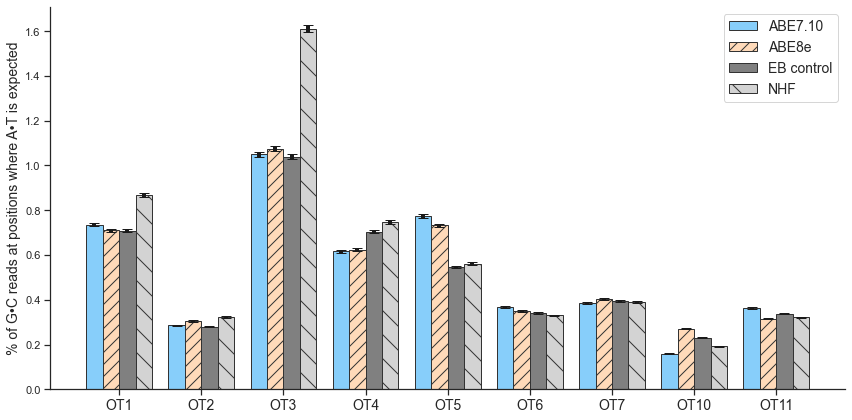

In [238]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

x = np.arange(len(labels))
width = 0.20

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - 1.5*width, 
                ABE710_bars, 
                width, 
                label='ABE7.10', 
                yerr=ABE710_errors,
                capsize=5, 
                error_kw={"elinewidth":4},
                facecolor ='lightskyblue',
                linewidth=1.0, 
                hatch = "",
                edgecolor=".2")
rects2 = ax.bar(x - 0.5*width, 
                ABE8e_bars, 
                width, 
                label='ABE8e', 
                yerr=ABE8e_errors,
                capsize=5, 
                error_kw={"elinewidth":4},
                facecolor ='peachpuff',
                linewidth=1.0, 
                hatch = "//",
                edgecolor=".2")
rects3 = ax.bar(x + 0.5*width, 
                EB5control_bars, 
                width, 
                label='EB control', 
                yerr=EB5control_errors,
                capsize=5, 
                error_kw={"elinewidth":4},
                facecolor ='gray',
                linewidth=1.0, 
                hatch = "",
                edgecolor=".2")
rects4 = ax.bar(x + 1.5*width, 
                NHF_bars, 
                width, 
                label='NHF', 
                yerr=NHF_errors,
                capsize=5, 
                error_kw={"elinewidth":4},
                facecolor ='lightgray',
                linewidth=1.0, 
                hatch = "\\",
                edgecolor=".2")

ax.set_ylabel('% of G•C reads at positions where A•T is expected', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=14)
ax.legend(fontsize=14)

fig.tight_layout()

plt.savefig("26042022_offs_errorbar.png", dpi=300)

# Dose - dependent
### C1 = EB5 control
### C2 = ABE8e high
### C3 = ABE8e low
### C4 = ABE8e medium
### C5 = ABE7.10

# dose dependent on-target normalised 

In [ ]:
ABE710_files = sorted([fn for fn in all_stats if ("on-C5_S26" in fn)]) 
ABE8e_high_files = sorted([fn for fn in all_stats if ("on-C2_S23" in fn)])
ABE8e_medium_files = sorted([fn for fn in all_stats if ("on-C4_S25" in fn)])
ABE8e_low_files = sorted([fn for fn in all_stats if ("on-C3_S24" in fn)])
EB5control_files = sorted([fn for fn in all_stats if "on-C1_S2" in fn])
NHF_files = sorted([fn for fn in all_stats if "on-C1_S22" in fn])

In [ ]:
ordering = [0]
target_strand = ['p']
ABE710_files = [ABE710_files[i] for i  in ordering]
ABE8e_high_files =  [ABE8e_high_files[i] for i  in ordering]
ABE8e_medium_files =  [ABE8e_medium_files[i] for i  in ordering]
ABE8e_low_files =  [ABE8e_low_files[i] for i  in ordering]
EB5control_files =  [EB5control_files[i] for i  in ordering]
NHF_files =  [NHF_files[i] for i  in ordering]
labels = ["On-target c.5047, dose-dependent"]

In [ ]:
def get_counts_and_nobs_ontarget_dose_dependent(editor_files, target_strand):
    counts = []
    nobs = []
    assert len(editor_files) == len(target_strand)
    for idx in range(len(editor_files)):
        fn = editor_files[idx]
        strand = target_strand[idx]
        df = pd.read_csv(fn, index_col=0)
        if idx == 0 : # for on target, chr3, 48580586
            # mutation:
            mut = df.iloc[7, :]
            assert mut["pos"] == 48580586
            counts.append(mut["G_pp"])
            nobs.append(mut["reads_pp"])
            A_G_mut_proc = mut["G_pp"]/mut["reads_pp"]*100
            efficiency = (A_G_mut_proc - 57.25)/ (100 - 57.25)*100
            print(f"efficiency {efficiency:.2f}")
    return np.array(counts), np.array(nobs)
    
print("# ------------------------ ABE710_files")
ABE710_bars, ABE710_errors, ABE710_counts, ABE710_nobs = get_bars_errors(ABE710_files, 
                                                                         target_strand,
                                                                         get_counts_and_nobs=get_counts_and_nobs_ontarget_dose_dependent,
                                                                         normalize=57.25
                                                                        )
print("# ------------------------ ABE8e_files_high")
ABE8e_bars_high, ABE8e_errors_high, ABE8e_counts_high, ABE8e_nobs_high = get_bars_errors(ABE8e_high_files, 
                                                                     target_strand,
                                                                     get_counts_and_nobs=get_counts_and_nobs_ontarget_dose_dependent,
                                                                     normalize=57.25
                                                                    )
print("# ------------------------ ABE8e_files_medium")
ABE8e_bars_medium, ABE8e_errors_medium, ABE8e_counts_medium, ABE8e_nobs_medium = get_bars_errors(ABE8e_medium_files, 
                                                                     target_strand,
                                                                     get_counts_and_nobs=get_counts_and_nobs_ontarget_dose_dependent,
                                                                     normalize=57.25
                                                                    )
print("# ------------------------ ABE8e_files_low")
ABE8e_bars_low, ABE8e_errors_low, ABE8e_counts_low, ABE8e_nobs_low = get_bars_errors(ABE8e_low_files, 
                                                                     target_strand,
                                                                     get_counts_and_nobs=get_counts_and_nobs_ontarget_dose_dependent,
                                                                     normalize=57.25
                                                                    )

h0_rejection_hm = test_two_proportions(ABE8e_counts_high, ABE8e_nobs_high, ABE8e_counts_medium, ABE8e_nobs_medium, alpha=0.05)
h0_rejection_hl = test_two_proportions(ABE8e_counts_high, ABE8e_nobs_high, ABE8e_counts_low, ABE8e_nobs_low, alpha=0.05)
h0_rejection_lm = test_two_proportions(ABE8e_counts_low, ABE8e_nobs_low, ABE8e_counts_medium, ABE8e_nobs_medium, alpha=0.05)

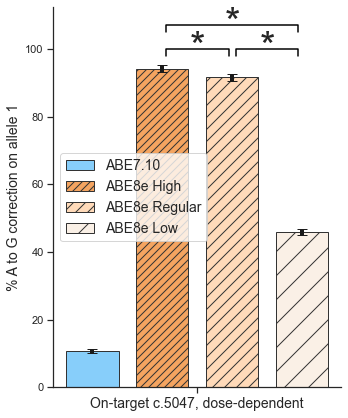

In [242]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


x = np.arange(len(labels))
width = 0.20
width_scalling = 0.75
x1 = x - 1.5*width
x2 = x - 0.5*width
x3 = x + 0.5*width
x4 = x + 1.5*width

fig, ax = plt.subplots(figsize=(5,6))
rects1 = ax.bar(x1, ABE710_bars, width_scalling*width, label='ABE7.10', 
                yerr=ABE710_errors,
                capsize=5, 
                error_kw={"elinewidth":4},
                facecolor ='lightskyblue',
                linewidth=1.0, 
                hatch = "",
                edgecolor=".2")
rects2 = ax.bar(x2, ABE8e_bars_high, width_scalling*width, label='ABE8e High', 
                yerr=ABE8e_errors_high,
                capsize=5, 
                error_kw={"elinewidth":4},
                facecolor ='sandybrown',
                linewidth=1.0, 
                hatch = "///",
                edgecolor=".2")
rects3 = ax.bar(x3, ABE8e_bars_medium, width_scalling*width, label='ABE8e Regular',
                yerr=ABE8e_errors_medium,
                capsize=5, 
                error_kw={"elinewidth":4},
                facecolor ='peachpuff',
                linewidth=1.0, 
                hatch = "//",
                edgecolor=".2")
rects4 = ax.bar(x4, ABE8e_bars_low, width_scalling*width, label='ABE8e Low',
                yerr=ABE8e_errors_low,
                capsize=5, 
                error_kw={"elinewidth":4},
                facecolor ='linen',
                linewidth=1.0, 
                hatch = "/",
                edgecolor=".2")

shortening = 0.01
tick = 2
for xx1,xx2, asterisk in zip(x2, x3, h0_rejection_hm):
    if asterisk:
        level = 100
        ax.plot([xx1+shortening,xx1+shortening, xx2-shortening,xx2-shortening],[level-tick,level,level,level-tick],color="black")
        ax.text((xx1+xx2)/2, level, '*', horizontalalignment='center', verticalalignment='center', fontsize=40)

for xx1,xx2, asterisk in zip(x2, x4, h0_rejection_hl):
    if asterisk:
        level = 107
        ax.plot([xx1+shortening,xx1+shortening, xx2-shortening,xx2-shortening],[level-tick,level,level,level-tick],color="black")
        ax.text((xx1+xx2)/2, level, '*', horizontalalignment='center', verticalalignment='center', fontsize=40)


for xx1,xx2, asterisk in zip(x3, x4, h0_rejection_lm):
    if asterisk:
        level = 100
        ax.plot([xx1+shortening,xx1+shortening, xx2-shortening,xx2-shortening],[level-tick,level,level,level-tick],color="black")
        ax.text((xx1+xx2)/2, level, '*', horizontalalignment='center', verticalalignment='center', fontsize=40)



ax.set_ylabel('% A to G correction on allele 1',fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=14)
ax.legend(loc='center left',fontsize=14)

fig.tight_layout()
plt.savefig("26042022-ontargetc5047-dose_dependent_efficiency_errorbar.png", dpi=300)

# Bystander dose-dependent, normalised

In [ ]:
ABE710_files = sorted([fn for fn in all_stats if ("on-C5_S26" in fn)]) 
ABE8e_high_files = sorted([fn for fn in all_stats if ("on-C2_S23" in fn)])
ABE8e_medium_files = sorted([fn for fn in all_stats if ("on-C4_S25" in fn)])
ABE8e_low_files = sorted([fn for fn in all_stats if ("on-C3_S24" in fn)])
EB5control_files = sorted([fn for fn in all_stats if "on-C1_S2" in fn])

In [ ]:
ordering = [0]
target_strand = ['p']
ABE710_files = [ABE710_files[i] for i  in ordering]
ABE8e_high_files =  [ABE8e_high_files[i] for i  in ordering]
ABE8e_medium_files =  [ABE8e_medium_files[i] for i  in ordering]
ABE8e_low_files =  [ABE8e_low_files[i] for i  in ordering]
EB5control_files =  [EB5control_files[i] for i  in ordering]
labels = ["Bystander c.5052, dose-dependent"]

In [ ]:
def get_counts_and_nobs_bystander_dose_dependent(editor_files, target_strand):
    counts = []
    nobs = []
    assert len(editor_files) == len(target_strand)
    for idx in range(len(editor_files)):
        fn = editor_files[idx]
        strand = target_strand[idx]
        df = pd.read_csv(fn, index_col=0)
        if idx == 0 : # for bystander, chr3, 48580581
            # bystander:
            bys = df.iloc[2, :]
            assert bys["pos"] == 48580581
            counts.append(bys["G_pp"])
            nobs.append(bys["reads_pp"])
            A_G_bys_proc = bys["G_pp"]/bys["reads_pp"]*100
            bystander = (A_G_bys_proc - 12.24)/(100 - 12.24)*100
            print(f"bystander {bystander:.2f}")
            print(f"A_G_bys_proc {A_G_bys_proc:.2f}")
    return np.array(counts), np.array(nobs)
    
print("# ------------------------ ABE710_files")
ABE710_bars, ABE710_errors, ABE710_counts, ABE710_nobs = get_bars_errors(ABE710_files, 
                                                                         target_strand,
                                                                         get_counts_and_nobs=get_counts_and_nobs_bystander_dose_dependent,
                                                                         normalize=12.24
                                                                        )
print("# ------------------------ ABE8e_files_high")
ABE8e_bars_high, ABE8e_errors_high, ABE8e_counts_high, ABE8e_nobs_high = get_bars_errors(ABE8e_high_files, 
                                                                     target_strand,
                                                                     get_counts_and_nobs=get_counts_and_nobs_bystander_dose_dependent,
                                                                     normalize=12.24
                                                                    )
print("# ------------------------ ABE8e_files_medium")
ABE8e_bars_medium, ABE8e_errors_medium, ABE8e_counts_medium, ABE8e_nobs_medium = get_bars_errors(ABE8e_medium_files, 
                                                                     target_strand,
                                                                     get_counts_and_nobs=get_counts_and_nobs_bystander_dose_dependent,
                                                                     normalize=12.24
                                                                    )
print("# ------------------------ ABE8e_files_low")
ABE8e_bars_low, ABE8e_errors_low, ABE8e_counts_low, ABE8e_nobs_low = get_bars_errors(ABE8e_low_files, 
                                                                     target_strand,
                                                                     get_counts_and_nobs=get_counts_and_nobs_bystander_dose_dependent,
                                                                     normalize=12.24
                                                                    )
print("# ------------------------ ABE8e_files_low")
EB5control_bars, EB5control_errors, EB5control_counts, EB5control_nobs = get_bars_errors(EB5control_files, 
                                                                     target_strand,
                                                                     get_counts_and_nobs=get_counts_and_nobs_bystander_dose_dependent,
                                                                     normalize=12.24
                                                                    )

h0_rejection_hm = test_two_proportions(ABE8e_counts_high, ABE8e_nobs_high, ABE8e_counts_medium, ABE8e_nobs_medium, alpha=0.05)
h0_rejection_hl = test_two_proportions(ABE8e_counts_high, ABE8e_nobs_high, ABE8e_counts_low, ABE8e_nobs_low, alpha=0.05)
h0_rejection_lm = test_two_proportions(ABE8e_counts_low, ABE8e_nobs_low, ABE8e_counts_medium, ABE8e_nobs_medium, alpha=0.05)

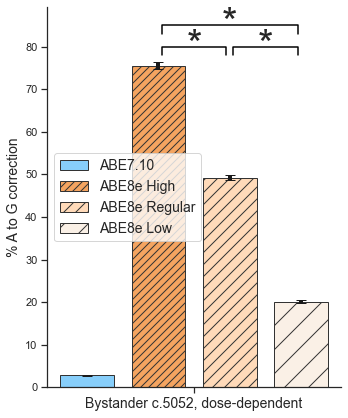

In [246]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


x = np.arange(len(labels))
width = 0.20
width_scalling = 0.75
x1 = x - 1.5*width
x2 = x - 0.5*width
x3 = x + 0.5*width
x4 = x + 1.5*width

fig, ax = plt.subplots(figsize=(5,6))
rects1 = ax.bar(x1, ABE710_bars, width_scalling*width, label='ABE7.10', 
                yerr=ABE710_errors,
                capsize=5, 
                error_kw={"elinewidth":4},
                facecolor ='lightskyblue',
                linewidth=1.0, 
                hatch = "",
                edgecolor=".2")
rects2 = ax.bar(x2, ABE8e_bars_high, width_scalling*width, label='ABE8e High', 
                yerr=ABE8e_errors_high,
                capsize=5, 
                error_kw={"elinewidth":4},
                facecolor ='sandybrown',
                linewidth=1.0, 
                hatch = "///",
                edgecolor=".2")
rects3 = ax.bar(x3, ABE8e_bars_medium, width_scalling*width, label='ABE8e Regular',
                yerr=ABE8e_errors_medium,
                capsize=5, 
                error_kw={"elinewidth":4},
                facecolor ='peachpuff',
                linewidth=1.0, 
                hatch = "//",
                edgecolor=".2")
rects4 = ax.bar(x4, ABE8e_bars_low, width_scalling*width, label='ABE8e Low',
                yerr=ABE8e_errors_low,
                capsize=5, 
                error_kw={"elinewidth":4},
                facecolor ='linen',
                linewidth=1.0, 
                hatch = "/",
                edgecolor=".2")

shortening = 0.01
tick = 2
for xx1,xx2, asterisk in zip(x2, x3, h0_rejection_hm):
    if asterisk:
        level = 80
        ax.plot([xx1+shortening,xx1+shortening, xx2-shortening,xx2-shortening],[level-tick,level,level,level-tick],color="black")
        ax.text((xx1+xx2)/2, level, '*', horizontalalignment='center', verticalalignment='center', fontsize=40)

for xx1,xx2, asterisk in zip(x2, x4, h0_rejection_hl):
    if asterisk:
        level = 85
        ax.plot([xx1+shortening,xx1+shortening, xx2-shortening,xx2-shortening],[level-tick,level,level,level-tick],color="black")
        ax.text((xx1+xx2)/2, level, '*', horizontalalignment='center', verticalalignment='center', fontsize=40)


for xx1,xx2, asterisk in zip(x3, x4, h0_rejection_lm):
    if asterisk:
        level = 80
        ax.plot([xx1+shortening,xx1+shortening, xx2-shortening,xx2-shortening],[level-tick,level,level,level-tick],color="black")
        ax.text((xx1+xx2)/2, level, '*', horizontalalignment='center', verticalalignment='center', fontsize=40)



ax.set_ylabel('% A to G correction',fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=14)
ax.legend(loc='center left',fontsize=14)

fig.tight_layout()
plt.savefig("26042022-bystanderc5052-dose_dependent_normalised_errorbar.png", dpi=300)